In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot
from func_model_performance import queryRangePostCode, Baseline, compile_and_fit

np.set_printoptions(precision = 4)
tf.random.set_seed(42)

2023-01-27 20:31:11.892875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 20:31:17.650303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 20:31:17.650923: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
pathes_household = {"gas": "./data/Generated Data/master_competitor_market_prices_gas.csv", 
                    "power": "./data/Generated Data/master_competitor_market_prices_power.csv"}
pathes_market = {"gas": "./data/Generated Data/gas_prices.csv", 
                 "power": "./data/Generated Data/power_prices.csv"}

In [3]:
energy = "power"

path_household = pathes_household[energy]
path_market = pathes_market[energy]

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_household, usecols=usecols, dtype = dtypes)
market_data = pd.read_csv(path_market, header = [0], parse_dates=["Dates"])

market_data.set_index("Dates", inplace = True)
market_data["moving_average"] = market_data.avg_price.ewm(alpha=0.1, adjust=False).mean()
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [4]:
norm_layer = tf.keras.layers.Normalization(axis = 1)
consRange = 2000
postCode = "81737"

input = queryRangePostCode(household, consumption_range=consRange, post_code=postCode, rank_range=[6,10])
input = input.join(market_data[["avg_price", "moving_average"]]).interpolate(method = "time", axis = 0)
norm_layer.adapt(input)
norm_input = norm_layer(input)
norm_input = pd.DataFrame(norm_input, columns = input.columns, index = input.index)

In [5]:
shift = 5
input_width = 10

train_df = norm_input[:-shift]
val_df = norm_input[-(2*shift+input_width):]

In [6]:
print(train_df.shape)
print(val_df.shape)

(411, 3)
(20, 3)


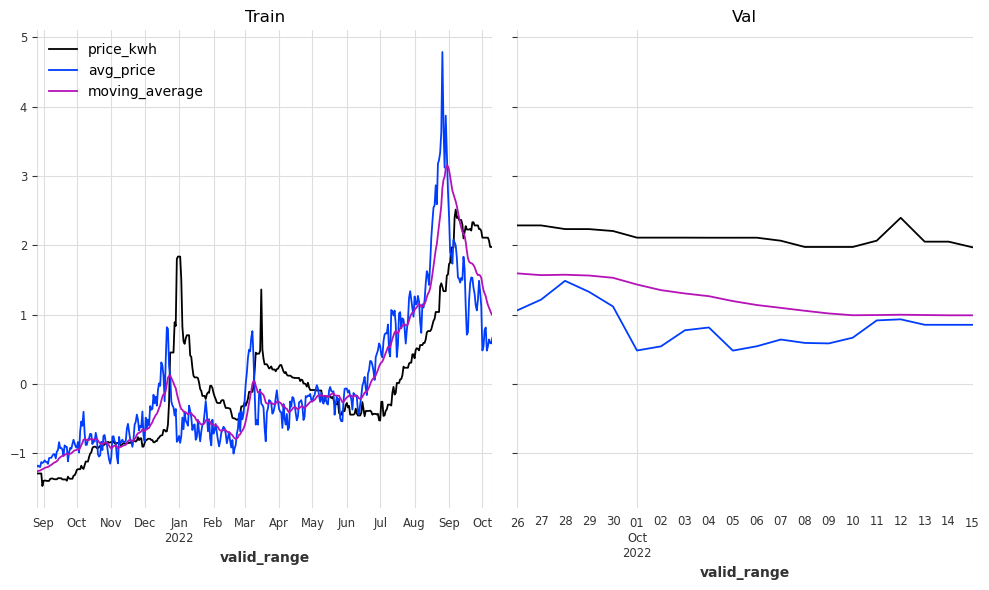

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, 
                               figsize = (10,6), 
                               #gridspec_kw={'width_ratios': [train_size, 1-train_size]}, 
                               sharey= "row")

ax1 = train_df.plot(ax = ax1, legend = True)
ax2 = val_df.plot(ax = ax2, legend = False)
ax1.set_title("Train")
ax2.set_title("Val")
fig.tight_layout()

# Definition

In [8]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=shift,
    label_columns=['price_kwh'], train_df=train_df, val_df=val_df)

single_step_window

Total window size: 6
Input indices: [0]
Label indices: [5]
Label column name(s): ['price_kwh']

In [9]:
multi_in_multi_out = WindowGenerator(
    input_width=input_width,
    label_width=input_width,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

multi_in_multi_out

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['price_kwh']

In [10]:
multi_in_single_out = WindowGenerator(
    input_width=input_width,
    label_width=1,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

multi_in_single_out

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [14]
Label column name(s): ['price_kwh']

# Model Declaration

In [11]:
baseline = Baseline(label_index=0)

In [12]:
# Dense NN with single step

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [13]:
# Dense Neural Network with Multiple inputs and outputs

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [14]:
#Convolutional NN with 1 Dense Layer

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(input_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [15]:
#Simple LSTM Model

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [16]:
# LSTM Model with additional Dense Layer

lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation="sigmoid"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [17]:
# #Print weights of linear model
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

# Compile and fit Models

In [18]:
error_metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]

In [19]:
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=error_metrics)

val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 257ms/step - loss: 0.0187 - mean_absolute_percentage_error: 5.2699


In [20]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 73ms/step - loss: 0.4188 - mean_absolute_percentage_error: 29.8105


In [21]:
history = compile_and_fit(multi_step_dense, multi_in_multi_out)

val_performance['Multi step dense'] = multi_step_dense.evaluate(multi_in_multi_out.val)

1/1 [==============================] - 0s 92ms/step - loss: 0.1565 - mean_absolute_percentage_error: 18.1928


In [22]:
history = compile_and_fit(conv_model, multi_in_multi_out)

val_performance['Conv'] = conv_model.evaluate(multi_in_multi_out.val)

1/1 [==============================] - 0s 91ms/step - loss: 0.0265 - mean_absolute_percentage_error: 5.7778


In [23]:
history = compile_and_fit(lstm_model, multi_in_single_out)

val_performance['LSTM'] = lstm_model.evaluate(multi_in_single_out.val)

1/1 [==============================] - 0s 101ms/step - loss: 0.0522 - mean_absolute_percentage_error: 8.1234


In [24]:
history = compile_and_fit(lstm_DNN_model, multi_in_single_out)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(multi_in_single_out.val)

1/1 [==============================] - 0s 79ms/step - loss: 0.0906 - mean_absolute_percentage_error: 12.3611


# Performance comparisson

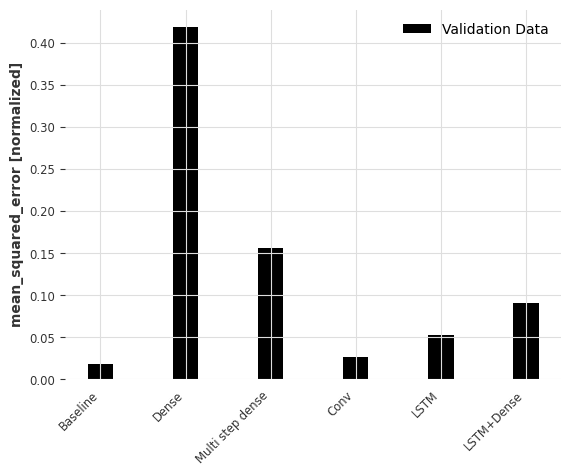

In [27]:
x = np.arange(len(val_performance))
width = 0.3
metric_name = 'loss'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mse = [v[metric_index] for v in val_performance.values()]

plt.ylabel('mean_squared_error [normalized]')
plt.bar(x, val_mse, width, label='Validation Data')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45, ha = "right")
#plt.ylim((0,0.5))
_ = plt.legend()


In [28]:
lstm_model.metrics_names

['loss', 'mean_absolute_percentage_error']

In [29]:
print(f'{"MSE":>26s}{"MAE":>9s}{"MAPE":>9s}')
for name, value in val_performance.items():
  print(f'{name:20s}: {value[metric_index]:0.4f}   {value[1]:0.4f}   {value[2]:0.4f}')


                       MSE      MAE     MAPE


IndexError: list index out of range

# Plot timeseries

In [30]:
def predict_with_date(self: tf.keras.Model, window: WindowGenerator, df) -> pd.DataFrame:
    model_input = window.make_dataset(df)
    predictions = self.predict(model_input, verbose = 0)
    dates = df.index[slice(window.total_window_size-1,None)]
    return pd.Series(predictions[:,predictions.shape[1]-1].flatten(), index = dates)

tf.keras.Model.predict_with_date = predict_with_date

def inverse_norm_price_p_kwh(df):
    sd = np.sqrt(norm_layer.variance[0,0])
    mean = norm_layer.mean[0,0]
    return df*sd + mean

def plot(self, window: WindowGenerator, df: pd.DataFrame):
    fig = plt.figure()
    plt.plot(
        inverse_norm_price_p_kwh(
            baseline.predict_with_date(window = window, df = df)), 
                                       label = "Baseline")
    
    plt.plot(
        inverse_norm_price_p_kwh(
        self.predict_with_date(window = window, df = df)), 
                                        label = "Predictions")
    
    plt.plot(
        inverse_norm_price_p_kwh(df["price_kwh"]), 
                                    label = "Original")
    
    plt.xticks(rotation = 45)
    plt.legend()

tf.keras.Model.plot = plot

In [31]:
window = multi_in_single_out
plot_data = val_df

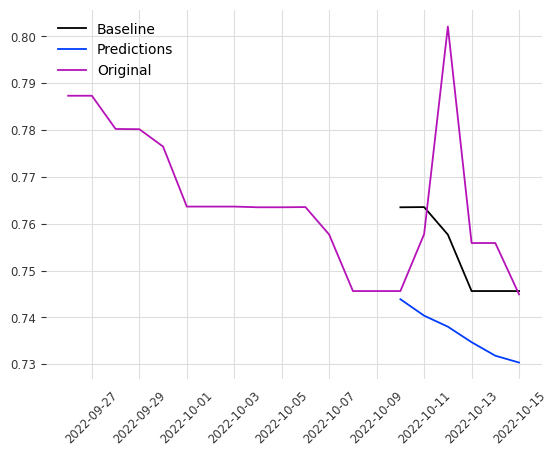

In [32]:
lstm_model.plot(window = window, df = plot_data)

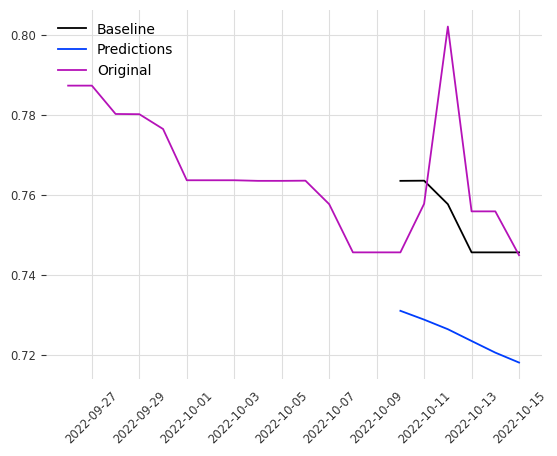

In [33]:
lstm_DNN_model.plot(window = window, df = plot_data)

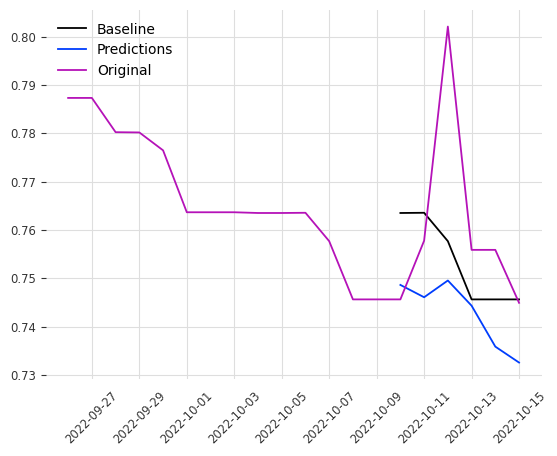

In [34]:
conv_model.plot(window, plot_data)

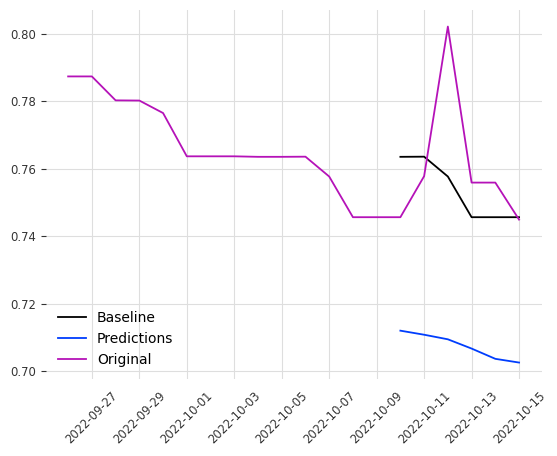

In [35]:
multi_step_dense.plot(window, plot_data)

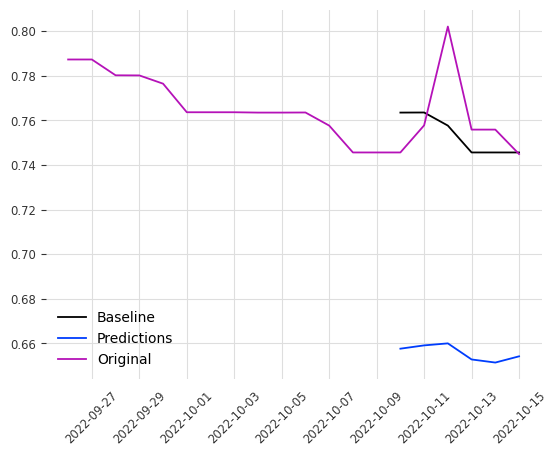

In [36]:
dense.plot(window, plot_data)